# Fake News Detector
#### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import re

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK
from nltk.corpus import stopwords
from textblob import Word
from nltk.stem import WordNetLemmatizer

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

#### Test / Train Dataset Load

In [2]:
data = pd.read_csv('fake_news_train.csv')
data.head()

,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


In [3]:
data_test = pd.read_csv('test_fake_news.csv')
data_test.head()

,Unnamed: 0,ID,title,text
0,0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...
1,1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...
2,2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...
3,3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...
4,4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...


#### Data Cleaning

In [4]:
def find_duplicates():
    print("Duplicates in Title field:", sum(data.duplicated(subset="title", keep="first")))
    print("Duplicates in Text field:", sum(data.duplicated(subset="text", keep="first")))
    print("Duplicate rows:", sum(data[data.text.notnull()].duplicated(subset=["text", "title", "label", "X1", "X2"], keep="first")))

find_duplicates()

Duplicates in Title field: 31
Duplicates in Text field: 160
Duplicate rows: 9


In [5]:
data.drop_duplicates(subset=["text", "title", "label", "X1", "X2"], keep="first", inplace=True)
print("Number of duplicates after removal")
find_duplicates()

Number of duplicates after removal
Duplicates in Title field: 22
Duplicates in Text field: 151
Duplicate rows: 0


In [6]:
misplaced_rows_label = (data["label"] != "FAKE" ) & (data["label"] != "REAL")
print("Number of rows that have misplaced data:", sum(misplaced_rows_label))
data[misplaced_rows_label].head()

Number of rows that have misplaced data: 33


,ID,title,text,label,X1,X2
192,599,Election Day: No Legal Pot In Ohio,Democrats Lose In The South,Election Day: No Legal Pot In Ohio; Democrats ...,REAL,NaN
308,10194,Who rode it best? Jesse Jackson mounts up to f...,Leonardo DiCaprio to the rescue?,Who rode it best? Jesse Jackson mounts up to f...,FAKE,NaN
382,356,Black Hawk crashes off Florida,human remains found,(CNN) Thick fog forced authorities to suspend ...,REAL,NaN
660,2786,Afghanistan: 19 die in air attacks on hospital,U.S. investigating,(CNN) Aerial bombardments blew apart a Doctors...,REAL,NaN
889,3622,Al Qaeda rep says group directed Paris magazin...,US issues travel warning,A member of Al Qaeda's branch in Yemen said Fr...,REAL,NaN


33 rows have misplaced data, they do not have the labels, but data from text field

In [7]:
misplaced_rows_X1 = (data["X1"] == "FAKE" ) | (data["X1"] == "REAL")
print("Number of rows that have misplaced data:", sum(misplaced_rows_X1))
data[misplaced_rows_X1].head()

Number of rows that have misplaced data: 31


,ID,title,text,label,X1,X2
192,599,Election Day: No Legal Pot In Ohio,Democrats Lose In The South,Election Day: No Legal Pot In Ohio; Democrats ...,REAL,NaN
308,10194,Who rode it best? Jesse Jackson mounts up to f...,Leonardo DiCaprio to the rescue?,Who rode it best? Jesse Jackson mounts up to f...,FAKE,NaN
382,356,Black Hawk crashes off Florida,human remains found,(CNN) Thick fog forced authorities to suspend ...,REAL,NaN
660,2786,Afghanistan: 19 die in air attacks on hospital,U.S. investigating,(CNN) Aerial bombardments blew apart a Doctors...,REAL,NaN
889,3622,Al Qaeda rep says group directed Paris magazin...,US issues travel warning,A member of Al Qaeda's branch in Yemen said Fr...,REAL,NaN


labels in 31 of those rows are in X1 column

In [8]:
misplaced_rows_X2 = (data["X2"] == "FAKE" ) | (data["X2"] == "REAL")
print("Number of rows that have misplaced data:", sum(misplaced_rows_X2))
data[misplaced_rows_X2].head()

Number of rows that have misplaced data: 2


,ID,title,text,label,X1,X2
2184,9,Planned Parenthood’s lobbying effort,pay raises for federal workers,and the future Fed rates,PLANNED PARENTHOOD’S LOBBYING GETS AGGRESSIVE....,REAL
3537,6268,Chart Of The Day: Since 2009—–Recovery For The 5%,Stagnation for the 95%,Chart Of The Day: Since 2009 Recovery For The 5%,Stagnation for the 95%,FAKE


And in 2 cases labels are in X2 column.  

In [9]:
# Find the indexes where X1 field contains REAL/FAKE values
idx_X1_label = (data["X1"] == "FAKE") | (data["X1"] == "REAL")

# Create a new field called 'tag' and fill it with REAL/FAKE values from X1
data.loc[idx_X1_label, "tag"] = data.loc[idx_X1_label, "X1"].values

# We do the same for X2 field
idx_X2_label = (data["X2"] == "FAKE") | (data["X2"] == "REAL")
data.loc[idx_X2_label, "tag"] = data.loc[idx_X2_label, "X2"].values
data.loc[idx_X2_label, "X2"] = np.nan

# Then finally we fill the rest of the values in 'target' field from the REAL/FAKE values from 'label' field
data.tag = data.tag.fillna(value=data.label)

print("Missing values in 'tag' field: ", sum(data.tag.isnull()))
print("Proportion of fake/real news in training data:\n", data.tag.value_counts())

Missing values in 'tag' field:  0
Proportion of fake/real news in training data:
 tag
REAL    2000
FAKE    1990
Name: count, dtype: int64


In [10]:
# Clear REAL/FAKE values in X1
data.loc[idx_X1_label, "X1"] = np.nan

# Clear REAL/FAKE values in label
idx_label = (data["label"] == "FAKE") | (data["label"] == "REAL")
data.loc[idx_label, "label"] = np.nan

# Replacing the NaN values in X1 and label fields with ""
data.X1.fillna("", inplace=True)
data.label.fillna("", inplace=True)

# Merge title, text, label and X1 column to combine all text related values.
data["full_text"] = data[["title", "text", "label", "X1"]].apply(
    lambda x: ". ".join(x.astype(str)), axis=1
)

In order to have identical data shape in test and train datasets, we also combine "title" and "text" fields in the test dataset

In [11]:
data_test["full_text"] = data_test[["title", "text"]].apply(
    lambda x: ". ".join(x.astype(str)), axis=1
)

#### Feature Engineering

we process text transformations using regular expressions, that will possibly help model to predict better:
* html tag removal
* numeric characters removal
* punctuation removal
* non-alphabetic character removal
* stop words removal
* remove words that are less than 2 char long
* reduce words to its root forms

In [12]:
data["full_text"] = data["full_text"].str.replace(r"<.*?>", "")
data_test["full_text"] = data_test["full_text"].str.replace(r"<.*?>", "")
data["full_text"] = data["full_text"].str.replace(r"\d+", "")
data_test["full_text"] = data_test["full_text"].str.replace(r"\d+", "")
data['full_text'] = data['full_text'].str.replace(r"[^\w\s]", " ")
data_test['full_text'] = data_test['full_text'].str.replace(r"[^\w\s]", " ")
data["full_text"] = data["full_text"].str.replace(r"[^A-Za-z]", " ")
data_test["full_text"] = data_test["full_text"].str.replace(r"[^A-Za-z]", " ")
stop = stopwords.words("english")
data["full_text"] = data["full_text"].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data_test["full_text"] = data_test["full_text"].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data["full_text"] = data["full_text"].apply(lambda x: " ".join(x for x in x.split() if len(x) > 1))
data_test["full_text"] = data_test["full_text"].apply(lambda x: " ".join(x for x in x.split() if len(x) > 1))
data["full_text"] = data["full_text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data_test["full_text"] = data_test["full_text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


#### Bigrams
These are useful to identify what type of news in the dataset. Graph shows that it mainly contains news regarding US politics


/var/folders/c6/mw_ts3n12lz1m4fh1scsp06c0000gn/T/ipykernel_25301/298294555.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45)


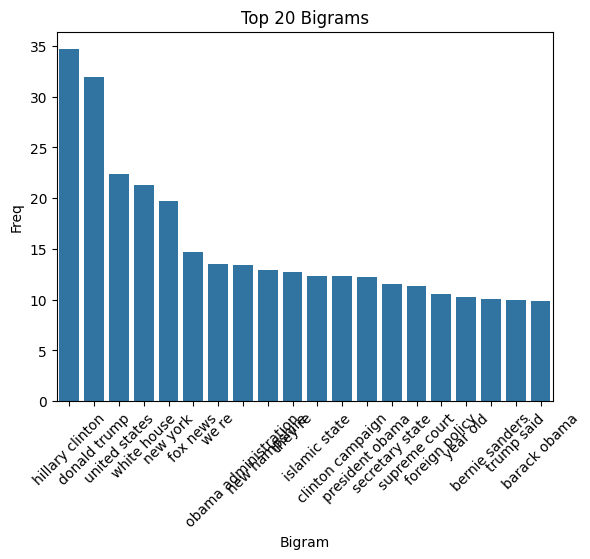

In [13]:
def get_top_n_bigram(corpus, n=None):
    vec = TfidfVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(data['full_text'], 20)
df_bigram = pd.DataFrame(common_words, columns=["Bigram", "Freq"])

g = sns.barplot(x="Bigram", y="Freq", data=df_bigram)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.title('Top 20 Bigrams')
plt.show()

#### Modelling

In [14]:
#Splitting train dataset into train and test sets

X = data["full_text"]
y = data["tag"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Naive Bayes Classifier
nb_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
               ('clf', MultinomialNB())])
pipe_params_nb = {
    'tfidf__max_df': [0.95],
    'tfidf__max_features': [50000],
    'tfidf__ngram_range': [(1,2), (1,3)],
    "clf__alpha": [0.002],
}
model_nb_gs = GridSearchCV(
    nb_pipeline, param_grid=pipe_params_nb, cv=3, verbose=True
)
model_nb_gs.fit(X_train, y_train)
print("Best score: ", model_nb_gs.best_score_)
print("Test score: ", model_nb_gs.score(X_test, y_test))
print("Best parameters: ", model_nb_gs.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score:  0.918859649122807
Test score:  0.9298245614035088
Best parameters:  {'clf__alpha': 0.002, 'tfidf__max_df': 0.95, 'tfidf__max_features': 50000, 'tfidf__ngram_range': (1, 3)}


In [16]:
# Passive Aggressive Classifier
pac_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', PassiveAggressiveClassifier(max_iter=50))])
# Tune GridSearchCV
pipe_params_pac = {'tfidf__max_df': [0.95,0.90],
               'tfidf__max_features': [50000],
               'tfidf__ngram_range': [(1,3),(1,4)],
               'clf__C': [0.75],
               'clf__loss': ['squared_hinge']}

model_pac_gs = GridSearchCV(pac_pipeline, param_grid=pipe_params_pac, cv=3)
model_pac_gs.fit(X_train, y_train);
print("Best score:", model_pac_gs.best_score_)
print("Test score", model_pac_gs.score(X_test, y_test))
print("Best parameters: ", model_pac_gs.best_params_)

Best score: 0.9304511278195489
Test score 0.9298245614035088
Best parameters:  {'clf__C': 0.75, 'clf__loss': 'squared_hinge', 'tfidf__max_df': 0.95, 'tfidf__max_features': 50000, 'tfidf__ngram_range': (1, 3)}


In [17]:
# SVM Classifier
svm_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', SGDClassifier(random_state=41))])
pipe_params_svm = {
                     'tfidf__ngram_range': ([(1,1),(1,2),(1,3)]),
                     'clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
                     'clf__max_iter': [1000], # number of epochs
                     'clf__loss': ['log_loss'], # logistic regression
                     'clf__penalty': ['l2'],
                     'clf__n_jobs': [-1]
}

model_svm_gs = GridSearchCV(svm_pipeline, param_grid= pipe_params_svm, cv = 3)
model_svm_gs.fit(X_train, y_train)

print("Best score: ", model_svm_gs.best_score_)
print("Test score: ", model_svm_gs.score(X_test, y_test))
print("Best parameters: ", model_svm_gs.best_params_)

Best score:  0.9194862155388471
Test score:  0.9097744360902256
Best parameters:  {'clf__alpha': 0.0001, 'clf__loss': 'log_loss', 'clf__max_iter': 1000, 'clf__n_jobs': -1, 'clf__penalty': 'l2', 'tfidf__ngram_range': (1, 1)}


The best score (~93%) has been achieved with Naive Bayes and Passive Aggressive Classifiers, PAC is chosen to be used to predict labels on test data as it shows better score on both train and test sets

In [62]:
#Test Data Classification
test_data_pred = model_pac_gs.predict(data_test['full_text'])
data_test["label"] = test_data_pred
predictions= data_test[['ID','label']]
predictions.to_csv("my_predictions.csv")